# Information Retrieval I #
## Assignment 2: retrieval models [100 points + 10 bonus points] ##
**TA**: Christophe Van Gysel (cvangysel@uva.nl; C3.258B, Science Park 904)

**Secondary TAs**: Harrie Oosterhuis, Nikos Voskarides

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a VirtualBox image that comes pre-loaded with an index and a Python installation. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-two assignment**, the deadline is **23:59 - 25 January, 2017**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

## IMPORTANT
We implemented loading and saving of all the dictionaries and all models, in order to be able to quickly run the notebook when re opening. After each dictionary creation there is a cell with the loading and saving of it, in order to easily comment out the dictionary creation function at will.

Check notes before the methods in case some clarifications are needed.

At least 8GB or RAM is needed to properly run all the code (not verified, but surely more than 6.5GB)

When first running the notebook, the project structure has to look like this
* Project_folder/
 * ap_88_89/
 * dictionaries/
 * index/
 * models/
 * npy/
 * runs/
 * iPython_notebook.ipynb

### Task 1: Implement and compare lexical IR methods [45 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, ..., 2000]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

In [23]:
import numpy as np
import pickle
import pyndri
from enum import Enum
import math
import time
import subprocess
import copy
import gensim
import logging
import pyndri.compat
import sys
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
import scipy.spatial.distance
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import scipy.stats
import matplotlib.pyplot as plt

## Dictionaries creation and initial preprocessing

In [24]:
index = pyndri.Index('index/')
token2id, id2token, _ = index.get_dictionary()
dictionary = pyndri.extract_dictionary(index)

min_index = index.document_base()
max_index = index.maximum_document()
documents_number = max_index - min_index

In [25]:
def save_dictionary(filename, dictionary):
    with open('dictionaries/' + filename + '.pk1', 'wb') as f:
        pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)
        
def load_dictionary(filename):
    with open('dictionaries/' + filename + '.pk1', 'rb') as f:
        return pickle.load(f)
    
def create_dictionaries():
    tf_dictionary = {}
    df_dictionary = {}
    p_dictionary = {}
    lengths = {}
    unique_tokens_dictionary = {}

    for d in range(min_index, max_index):
        tf_dictionary[d] = {}
        doc = index.document(d)
        tokens = set(doc[1])
        lengths[d] = len(doc[1])
        unique_tokens_dictionary[d] = len(tokens)
        for token in tokens:
            if token in df_dictionary:
                df_dictionary[token] += 1
            else:
                df_dictionary[token] = 1

        for token in doc[1]:
            if token in p_dictionary:
                p_dictionary[token] += 1
            else:
                p_dictionary[token] = 1

            if token in tf_dictionary[d]:
                tf_dictionary[d][token] += 1
            else:
                tf_dictionary[d][token] = 1

    C = 0
    for d in lengths:
        C += lengths[d]

    for key in p_dictionary:
        p_dictionary[key] /= C
    return tf_dictionary, df_dictionary, p_dictionary, lengths, unique_tokens_dictionary

In [26]:
tf_dictionary, df_dictionary, p_dictionary, lengths, unique_tokens_dictionary = create_dictionaries()
save_dictionary('tf_dictionary', tf_dictionary)
save_dictionary('df_dictionary', df_dictionary)
save_dictionary('p_dictionary', p_dictionary)
save_dictionary('lengths', lengths)
save_dictionary('unique_tokens_dictionary', unique_tokens_dictionary)

In [28]:
tf_dictionary = load_dictionary('tf_dictionary')
df_dictionary = load_dictionary('df_dictionary')
p_dictionary = load_dictionary('p_dictionary')
lengths = load_dictionary('lengths')
unique_tokens_dictionary = load_dictionary('unique_tokens_dictionary')

### Queries-related dictionaries

In [29]:
def create_queries_dictionaries():
    queries_dictionary = {}
    with open('ap_88_89/topics_title', 'r') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split(';')
            queries_dictionary[line[0]] = line[1]

    queries = set()
    validation_queries = {}
    with open('ap_88_89/qrel_validation', 'r') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split(' ')
            queries.add(line[0])

    for query in queries:
        validation_queries[query] = queries_dictionary[query]

    queries = set()
    test_queries = {}
    with open('ap_88_89/qrel_test', 'r') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split(' ')
            queries.add(line[0])

    for query in queries:
        test_queries[query] = queries_dictionary[query]
    return queries_dictionary, validation_queries, test_queries

In [30]:
queries_dictionary, validation_queries, test_queries = create_queries_dictionaries()
save_dictionary('queries_dictionary', queries_dictionary)
save_dictionary('validation_queries', validation_queries)
save_dictionary('test_queries', test_queries)

In [31]:
queries_dictionary = load_dictionary('queries_dictionary')
validation_queries = load_dictionary('validation_queries')
test_queries = load_dictionary('test_queries')

## TF-IDF

In [32]:
def tf(term, doc):
    token_id = token2id.get(term, 0)
    if(token_id not in tf_dictionary[doc]):
        return 0
    return tf_dictionary[doc][token_id]
    
def df(term):
    return df_dictionary[token2id.get(term, 0)]
    
def idf(term):
    return math.log(documents_number/df(term))

def tf_idf_term(term, doc):
    return math.log(1 + tf(term, doc)) * idf(term)

def tf_idf(query, doc, parameters):
    total = 0
    for token in query:
        total += tf_idf_term(token, doc)
    return total

## BM25

In [33]:
len_avg = sum(len(index.document(doc)[1]) for doc in range(min_index, max_index)) / documents_number

In [34]:
def length(doc):
    length = lengths[doc]
    return length if length > 0 else 1


def bm25(query, doc, parameters):
    b = parameters[0] # 0.75
    k1 = parameters[1] # 1.2
    k3 = parameters[2] # 1
    
    total = 0
    
    for token in query:
        tf_t = tf(token, doc)
        total += (k1 + 1) * tf_t * idf(token) / (k1 * ((1 - b) + b * (length(doc) / len_avg) + tf_t))
    return total

## Jelinek-Mercer

In [35]:
def jm(term, doc, lamb):
    p = p_dictionary[token2id.get(term, 0)]
    return (lamb * tf(term, doc)) / length(doc) + (1 - lamb) * p

def jelinek_mercer(query, doc, parameters):
    lamb = parameters[0]
    total = 1
    
    for word in query:
        total *= jm(word, doc, lamb)
    
    return total

## Dirichlet Prior

In [36]:
def dp(term, doc, mu):
    p = p_dictionary[token2id.get(term, 0)]
    
    return (tf(term, doc) + mu*p)/(length(doc) + mu)

def dirichlet_prior(query, doc, parameters):
    mu = parameters[0]
    
    total = 1
    
    for word in query:
        total *= dp(word, doc, mu)
    
    return total

## Absolute Discounting

In [37]:
def unique_tokens(d):
    return unique_tokens_dictionary[d]


def ad(term, doc, delta):
    p = p_dictionary[token2id.get(term, 0)]
    
    return (max(tf(term, doc) - delta, 0) + delta * unique_tokens(doc) * p) / length(doc)

def absolute_discounting(query, doc, parameters):
    delta = parameters[0]
    total = 1
    
    for word in query:
        total *= ad(word, doc, delta)
    
    return total

## Positional Language Models

In [38]:
class Kernel(Enum):
    GAUSSIAN = 1
    TRIANGLE = 2
    COSINE = 3
    CIRCLE = 4
    PASSAGE = 5
    

def kernel(i, j, kernel_type, parameters):
    sigma = parameters[1]
    
    difference = abs(j-i)
    
    if(kernel_type == Kernel.GAUSSIAN):
        return math.exp(-pow(i-j, 2)/(2*pow(sigma, 2)))
    else:
        if(difference > sigma):
            return 0;
        else:
            if(kernel_type == Kernel.TRIANGLE):
                return 1 - difference/sigma
            elif(kernel_type == Kernel.COSINE):
                return 0.5*(1 + np.cos(difference*math.pi/sigma))
            elif(kernel_type == Kernel.CIRCLE):
                return np.sqrt(1-pow(difference/sigma, 2))
            elif(kernel_type == Kernel.PASSAGE):
                return 1

def plm(query, doc, parameters):
    document = index.document(doc)[1]
    length_d = len(document)
    
    length_q = len(query)
    
    total = np.zeros(length_d)
    mu = parameters[0]
    sigma = parameters[1]
    kernel_type = Kernel[parameters[2]]
    
    query_LM = {}
    w_PLM = {}
    p_PLM = {}
    for term in query:
        if term in query_LM:
            query_LM[term] += 1.0
        else:
            query_LM[term] = 1.0
            w_PLM[term] = np.zeros(length_d)
            p_PLM[term] = np.zeros(length_d)
            
    for term in query_LM:
        query_LM[term] /= length_q
    
    for term in set(query):
        term_id = token2id.get(term,0)
        indices = [i for i, x in enumerate(document) if x == term_id]
        for ind in indices:
            if kernel_type == Kernel.GAUSSIAN:
                for i in range(max(0, ind-sigma*2), min(ind+sigma*2, length_d)):
                    w_PLM[term][i] += kernel(i, ind, kernel_type, parameters)
            else:
                for i in range(max(0, ind-sigma), min(ind+sigma, length_d)):
                    w_PLM[term][i] += kernel(i, ind, kernel_type, parameters)
    
    
    z_i = np.zeros(length_d)
    for i in range(length_d):
        for term in w_PLM:
            z_i[i] += w_PLM[term][i]
    
    
    
    for term in p_PLM:
        term_id = token2id.get(term,0)
        for i in range(length_d):
            p_PLM[term][i] = (w_PLM[term][i] + mu*p_dictionary[term_id])/(z_i[i] + mu)
            
            
    for i in range(length_d):
        temp = 0
        for term in set(query):
            temp += -query_LM[term]*math.log(query_LM[term]/p_PLM[term][i])
        
        total[i] = temp
        
    return max(total)

## Parameters estimation

In [39]:
class Scorings(Enum):
    TF_IDF = 1
    BM25 = 2
    JELINEK_MERCER = 3
    DIRICHLET_PRIOR = 4
    ABSOLUTE_DISCOUNTING = 5
    POSITION_LANGUAGE_MODEL = 6
    
class ScoringMethod():
    def __init__(self, scoring_type):
        if scoring_type == Scorings.TF_IDF:
            self.score = tf_idf
        elif scoring_type == Scorings.BM25:
            self.score = bm25
        elif scoring_type == Scorings.JELINEK_MERCER:
            self.score = jelinek_mercer
        elif scoring_type == Scorings.DIRICHLET_PRIOR:
            self.score = dirichlet_prior
        elif scoring_type == Scorings.ABSOLUTE_DISCOUNTING:
            self.score = absolute_discounting
        elif scoring_type == Scorings.POSITION_LANGUAGE_MODEL:
            self.score = plm
            
def get_scores(method, parameters, test):
    scores = {}
    
    if test:
        used_queries = test_queries
    else:
        used_queries = validation_queries
        
    for query in used_queries:
        scores[query] = []

        tokens = set(index.tokenize(used_queries[query]))
        if('' in tokens):
            tokens.remove('')
            
        ids = []
        for term in tokens:
            ids.append(token2id.get(term,0))
        
        for d in range(min_index, max_index): 
            doc = index.document(d)[1]
            if(len(doc) > 0 and any(x in ids for x in doc)):
                scores[query].append((d, method.score(tokens, d, parameters)))

        scores[query].sort(key=lambda x: x[1], reverse=True)
    return scores

def write_run(run_name, name, scores):
    with open('runs/' + run_name + '.run', 'w') as f:
        for query in scores:
            score_list = scores[query]
            for i in range(min(1000, len(score_list))):
                print(query,'Q0', index.document(score_list[i][0])[0], i+1, score_list[i][1], name, file=f)
                
def evaluate_run(run_name, test):
    command = 'trec_eval -m all_trec -q ap_88_89/'
    if test:
        command += 'qrel_test'
    else:
        command += 'qrel_validation'
    command += ' runs/' + run_name + '.run | grep "\sall\s"'
    output = str(subprocess.check_output(command, shell=True))
    return output

def evaluate_run_test(run_name, test):
    command = 'trec_eval -m all_trec -q ap_88_89/'
    if test:
        command += 'qrel_test'
    else:
        command += 'qrel_validation'
    command += ' runs/'  + run_name + '.run | grep -E  "(^ndcg_cut_10\s)|(^P_5\s)|(^recall_1000\s)|(^map_cut_1000\s)"'
    output = str(subprocess.check_output(command, shell=True))
    return output

def process_output(output): 
    output = output.replace("b'", '').replace('\\t', ' ').replace('\t', ' ').split('\\n')
    
    ndcg_10 = 0
    map_1000 = 0
    precision_5 = 0
    recall_1000 = 0
    for score in output:
        score = score.split()
        if score[0] == 'ndcg_cut_10':
            ndcg_10 = score[2]
        elif score[0] == 'map_cut_1000':
            map_1000 = score[2]
        elif score[0] == 'P_5':
            precision_5 = score[2]
        elif score[0] == 'recall_1000':
            recall_1000 = score[2]
    return ndcg_10, map_1000, precision_5, recall_1000

def process_output_t_test(output): 
    output = output.replace("b'", '').replace('\\t', ' ').replace('\t', ' ').split('\\n')
    
    ndcg_10 = 0
    map_1000 = 0
    precision_5 = 0
    recall_1000 = 0
    query_ndcg = []
    query_map = []
    query_prec = []
    query_recl = []
    for score in output:
        score = score.split()
        if score[0] == 'ndcg_cut_10':
            query_ndcg.append([score[1], score[2]])
        elif score[0] == 'map_cut_1000':
            query_map.append([score[1], score[2]])
        elif score[0] == 'P_5':
            query_prec.append([score[1], score[2]])
        elif score[0] == 'recall_1000':
            query_recl.append([score[1], score[2]])
    return query_ndcg, query_map, query_prec, query_recl

In [40]:
lambdas =  np.arange(0.1,1,0.1)
mus =  np.arange(500,2500,500)
deltas =  np.arange(0.1,1,0.1)
run_prefixes = ['JELINEK_MERCER', 'DIRICHLET_PRIOR', 'ABSOLUTE_DISCOUNTING']
run_parameters = [lambdas, mus, deltas]
kernels = ['GAUSSIAN', 'TRIANGLE', 'COSINE', 'CIRCLE', 'PASSAGE']
method = ScoringMethod(Scorings.POSITION_LANGUAGE_MODEL)
plm_prefix = 'POSITIONAL_LANGUAGE_MODEL'
sigma = 50

In [ ]:
def produce_rankings():
    for i in range(len(run_prefixes)):
        method = ScoringMethod(Scorings(i+3))
        prefix = run_prefixes[i]
        for j in range(len(run_parameters[i])):
            parameter = run_parameters[i][j]
            run_name = prefix + '_' + str(parameter)
            print(run_name)
            scores = get_scores(method, [parameter, sigma, kernel_type], False)
            write_run(run_name, prefix, scores)
    method = ScoringMethod(Scorings.POSITION_LANGUAGE_MODEL)
    for k in range(len(kernels)):
        for mu in mus:
            run_name = plm_prefix + '_' + str(mu) + '_' + kernels[k] 
            print(run_name)
            scores = get_scores(method, [parameter, sigma, kernel_type], False)
            write_run(run_name, plm_prefix, scores)
produce_rankings()

In [41]:
evaluation_scores = []
evaluation_scores_plm = []
def evaluate_runs_validation():

    print('parameter (ndcg_10, map_1000, precision_5, recall_1000)')
    print()

    for i in range(len(run_prefixes)):
        evaluation_scores.append([])
        prefix = run_prefixes[i]
        for j in range(len(run_parameters[i])):
            parameter = run_parameters[i][j]
            run_name = prefix + '_' + str(parameter)
            run_output = evaluate_run(run_name, False)
            evaluation_scores[i].append(process_output(run_output))

        print(prefix)
        for s in range(len(evaluation_scores[i])):
            print(run_parameters[i][s], evaluation_scores[i][s])
        print()

    for k in range(len(kernels)):
        evaluation_scores_plm.append([])
        for mu in mus:
            run_name = plm_prefix + '_' + str(mu) + '_' + kernels[k]
            run_output = evaluate_run(run_name, False)
            evaluation_scores_plm[k].append(process_output(run_output))

        print(plm_prefix + '_' + kernels[k])
        for s in range(len(evaluation_scores_plm[k])):
            print(mus[s], evaluation_scores_plm[k][s])
        print()
evaluate_runs_validation()

parameter (ndcg_10, map_1000, precision_5, recall_1000)

JELINEK_MERCER
0.1 ('0.3868', '0.2166', '0.3933', '0.6240')
0.2 ('0.3823', '0.2200', '0.3867', '0.6340')
0.3 ('0.3788', '0.2199', '0.3733', '0.6337')
0.4 ('0.3715', '0.2194', '0.3867', '0.6353')
0.5 ('0.3698', '0.2191', '0.3800', '0.6372')
0.6 ('0.3759', '0.2192', '0.3933', '0.6298')
0.7 ('0.3683', '0.2181', '0.3733', '0.6257')
0.8 ('0.3736', '0.2169', '0.3733', '0.6137')
0.9 ('0.3658', '0.2145', '0.3600', '0.6091')

DIRICHLET_PRIOR
500 ('0.3936', '0.2314', '0.4067', '0.6203')
1000 ('0.4040', '0.2395', '0.4000', '0.6305')
1500 ('0.4024', '0.2402', '0.4000', '0.6360')
2000 ('0.3998', '0.2403', '0.3933', '0.6302')

ABSOLUTE_DISCOUNTING
0.1 ('0.3744', '0.2226', '0.3600', '0.6054')
0.2 ('0.3783', '0.2254', '0.3600', '0.6083')
0.3 ('0.3869', '0.2274', '0.3800', '0.6093')
0.4 ('0.3858', '0.2289', '0.3800', '0.6116')
0.5 ('0.3792', '0.2296', '0.3800', '0.6171')
0.6 ('0.3785', '0.2322', '0.3800', '0.6294')
0.7 ('0.3885', '0.2326', '0.380

## Parameters analysis and choice
The analysis of each parameter has been done by calculating the *number of wins*, that consist on the total number of times one of the scores associated with a parameter value surpasses the ones of each other parameter. This calculation implicitly puts equal weight on each score value.

In [42]:
def calculate_parameter_wins():
    for score_index in range(len(evaluation_scores)):
        print(run_prefixes[score_index])
        scores = evaluation_scores[score_index]
        parameter_values = run_parameters[score_index]
        for i in range(len(scores)):
            print('parameter value:', parameter_values[i], end= ', ')
            wins = 0
            for j in range(len(scores)):
                if i!= j:
                    for k in range(len(scores[i])):
                        if scores[i][k] > scores[j][k]:
                            wins += 1
            print('avg wins: ', wins)
        print()
    
    for score_index in range(len(evaluation_scores_plm)):
        print(plm_prefix + '_' + kernels[score_index])
        scores = evaluation_scores_plm[score_index]
        parameter_values = mus
        for i in range(len(scores)):
            print('param value:', mus[i], end= ', ')
            wins = 0
            for j in range(len(scores)):
                if i!= j:
                    for k in range(len(scores[i])):
                        if scores[i][k] > scores[j][k]:
                            wins += 1
            print('avg wins:', wins)
        print()
calculate_parameter_wins()

JELINEK_MERCER
parameter value: 0.1, avg wins:  18
parameter value: 0.2, avg wins:  26
parameter value: 0.3, avg wins:  19
parameter value: 0.4, avg wins:  21
parameter value: 0.5, avg wins:  18
parameter value: 0.6, avg wins:  21
parameter value: 0.7, avg wins:  8
parameter value: 0.8, avg wins:  8
parameter value: 0.9, avg wins:  0

DIRICHLET_PRIOR
parameter value: 500, avg wins:  3
parameter value: 1000, avg wins:  7
parameter value: 1500, avg wins:  8
parameter value: 2000, avg wins:  5

ABSOLUTE_DISCOUNTING
parameter value: 0.1, avg wins:  0
parameter value: 0.2, avg wins:  3
parameter value: 0.3, avg wins:  12
parameter value: 0.4, avg wins:  13
parameter value: 0.5, avg wins:  14
parameter value: 0.6, avg wins:  16
parameter value: 0.7, avg wins:  22
parameter value: 0.8, avg wins:  25
parameter value: 0.9, avg wins:  28

POSITIONAL_LANGUAGE_MODEL_GAUSSIAN
param value: 500, avg wins: 6
param value: 1000, avg wins: 7
param value: 1500, avg wins: 4
param value: 2000, avg wins: 6



Looking at the results, the optimal values for each model are:
#### Jelinek Mercer
$\lambda = 0.2$

#### Dirichlet Prior
$\mu = 1500$

#### Absolute Discounting
$\delta = 0.9$

#### Positional Language Models
Gaussian $\mu = 1000$

Triangle $\mu = 500$

Cosine $\mu = 500$

Circle $\mu = 500$

Passage $\mu = 500$

## PLM plots

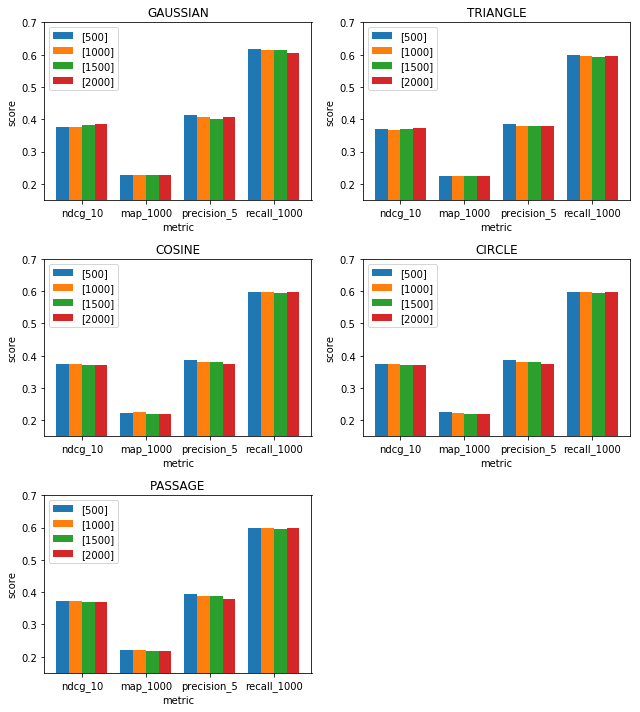

In [43]:
N = 4
ind = np.arange(N)
width = 0.20
plt.figure(figsize=(9, 10))

for k in range(len(kernels)):
    plt.subplot(3, 2, k+1)
    plt.title(kernels[k])
    for m in range(len(mus)):
        plt.bar(ind + m*width,[ float(n) for n in evaluation_scores_plm[k][m]], width, label=[mus[m]])
    plt.legend()
    plt.xticks(ind + width*m / 2, ['ndcg_10', 'map_1000', 'precision_5', 'recall_1000'])
    plt.ylim(ymin=0.15, ymax=0.7)
    plt.xlabel('metric')
    plt.ylabel('score')
plt.tight_layout()
plt.show()

## Evaluations

In [ ]:
test_parameters = [[], [0.75, 1.2, 1], [0.2], [1500], [0.9], [1000, 50, Kernel.GAUSSIAN], [500, 50, Kernel.TRIANGLE], 
                   [500, 50, Kernel.COSINE], [500, 50, Kernel.CIRCLE], [500, 50, Kernel.PASSAGE]]
run_test_prefixes = ['TF_IDF', 'BM25', 'JELINEK_MERCER', 'DIRICHLET_PRIOR', 'ABSOLUTE_DISCOUNTING',
                     'POSITIONAL_LANGUAGE_MODEL_GAUSSIAN', 'POSITIONAL_LANGUAGE_MODEL_TRIANGLE',
                     'POSITIONAL_LANGUAGE_MODEL_COSINE', 'POSITIONAL_LANGUAGE_MODEL_CIRCLE',
                     'POSITIONAL_LANGUAGE_MODEL_PASSAGE']
scorings_vals = [1, 2, 3, 4, 5, 6, 6, 6, 6, 6]


def produce_test_rankings():
    for i, scoring in enumerate(scorings_vals):
        method = ScoringMethod(Scorings(scoring))
        prefix = run_test_prefixes[i]
        parameter = test_parameters[i]
        run_name = prefix + '_TEST'
        if prefix == 'BM25':
            run_name = prefix + '_TEST_'
        elif 'POSITIONAL' in prefix:
            run_name = prefix + '_TEST'
        elif(len(parameter) > 0):  
            if len(parameter) == 1:
                run_name = prefix + '_TEST_' + str(parameter[0])
            else:
                run_name = prefix + '_TEST_' + str(parameter)
        print(run_name)
        scores = get_scores(method, parameter, True)
        write_run(run_name, prefix, scores)
produce_test_rankings()

Due to time limitations, we weren't able to create all the plm results (only gaussian kernel in our case). The below function contains the code to be used when all the runs are present.

In [44]:
test_scores_task1 = []
def evaluate_runs_test():
    test_parameters = [0.2, 1500, 0.9]
    test_parameters_plm = [1000, 500, 500, 500, 500]

    print('parameter (ndcg_10, map_1000, precision_5, recall_1000)')
    print()


    prefix = 'TF_IDF'
    run_name = 'TF_IDF' + '_TEST'
    run_output = evaluate_run(run_name, True)
    scores = process_output(run_output)
    test_scores_task1.append(scores)
    print(prefix)
    print('None', scores)
    print()

    prefix = 'BM25'
    run_name = 'BM25' + '_TEST'
    run_output = evaluate_run(run_name, True)
    scores = process_output(run_output)
    test_scores_task1.append(scores)
    print(prefix)
    print('None', scores)
    print()

    for i in range(len(run_prefixes)):
        prefix = run_prefixes[i]
        parameter = test_parameters[i]
        run_name = prefix + '_TEST_' + str(parameter)
        run_output = evaluate_run(run_name, True)
        scores = process_output(run_output)
        test_scores_task1.append(scores)
        print(prefix)
        print(parameter, scores)
        print()
       
    # Evaluating only one plm instance, as the other runs have not been created
    run_name = plm_prefix + '_' + 'GAUSSIAN' + '_TEST'
    run_output = evaluate_run(run_name, True)
    scores = process_output(run_output)
    test_scores_task1.append(scores)
    print(plm_prefix + '_' + 'GAUSSIAN')
    print('1000', scores)
    print()
    
    # ----Use this with all runs----
#     for score_index in range(len(kernels)):
#         run_name = plm_prefix + '_' + kernels[score_index] + '_TEST'
#         run_output = evaluate_run(run_name, True)
#         scores = process_output(run_output)

#         print(plm_prefix + '_' + kernels[score_index])
#         print(scores)
#         print()
        
evaluate_runs_test()

parameter (ndcg_10, map_1000, precision_5, recall_1000)

TF_IDF
None ('0.4207', '0.2163', '0.4333', '0.6528')

BM25
None ('0.4116', '0.2182', '0.4233', '0.6489')

JELINEK_MERCER
0.2 ('0.3648', '0.1945', '0.3667', '0.6291')

DIRICHLET_PRIOR
1500 ('0.4142', '0.2133', '0.4250', '0.6363')

ABSOLUTE_DISCOUNTING
0.9 ('0.4207', '0.2097', '0.4267', '0.6402')

POSITIONAL_LANGUAGE_MODEL_GAUSSIAN
1000 ('0.3702', '0.1899', '0.3800', '0.6102')



## Models plot

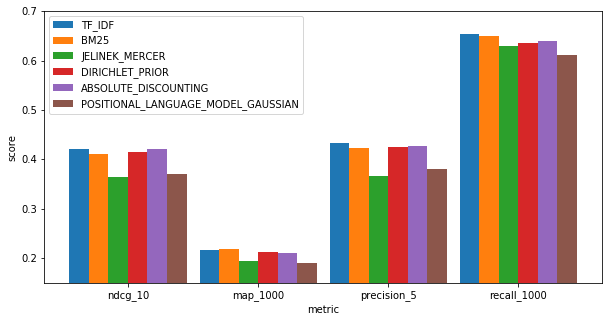

In [45]:
models_name = ['TF_IDF', 'BM25', 'JELINEK_MERCER', 'DIRICHLET_PRIOR', 'ABSOLUTE_DISCOUNTING', 'POSITIONAL_LANGUAGE_MODEL_GAUSSIAN']
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.15

plt.figure(figsize=(10, 5))
for k in range(len(test_scores_task1)):
    plt.bar(ind + k*width,[ float(n) for n in test_scores_task1[k]], width, label = models_name[k])
    plt.legend()
    plt.xticks(ind + width*k / 2, ['ndcg_10', 'map_1000', 'precision_5', 'recall_1000'])
    plt.ylim(ymin=0.15, ymax=0.7)
    plt.xlabel('metric')
    plt.ylabel('score')
plt.show()

## Significance Testing to determine best performing model

In [46]:
def column(matrix, i):
    return [float(row[i]) for row in matrix][:-1]

In order to see more detailed results, comment out the prints.

In [47]:
test_scores = []
t_test_prefixes = ["TF_IDF", "BM25", "JELINEK_MERCER", "DIRICHLET_PRIOR", "ABSOLUTE_DISCOUNTING",
                   "POSITIONAL_LANGUAGE_MODEL_GAUSSIAN"]
test_parameters = [[], [], [0.2], [1500], [0.9], []]

for i, prefix in enumerate(t_test_prefixes):
    test_scores.append([])
    parameter = test_parameters[i]
    if len(parameter) == 0:
        run_name = prefix + '_TEST'
    if len(parameter) == 1:
        run_name = prefix + '_TEST_' + str(parameter[0])
    elif(len(parameter)>0):
        run_name = prefix + '_TEST_' + str(parameter)
    run_output = evaluate_run_test(run_name, True)
    test_scores[i].append(process_output_t_test(run_output))
#     print(prefix)
#     for score in test_scores[i]:
#         for measure in score:
#             print(measure[-1:][0])
#     print()
    
wins = np.zeros(6)
bonferroni_alpha = 0.00083

for i in range(len(test_scores)):
    for j in range(i+1, 6):
        for m in range(4):
            p_val = scipy.stats.ttest_rel(column(test_scores[i][0][m], 1), column(test_scores[j][0][m], 1))[1]
            if(p_val < bonferroni_alpha and test_scores[i][0][m][-1][1] > test_scores[j][0][m][-1][1]):
                wins[i] += 1
            elif(p_val < bonferroni_alpha and test_scores[i][0][m][-1][1] < test_scores[j][0][m][-1][1]):
                wins[j] += 1
                
print("TF_IDF,", "BM25,", "JELINEK_MERCER,", "DIRICHLET_PRIOR,", "ABSOLUTE_DISCOUNTING,", "PLM_GAUSS")                
print(wins)

TF_IDF, BM25, JELINEK_MERCER, DIRICHLET_PRIOR, ABSOLUTE_DISCOUNTING, PLM_GAUSS
[ 2.  6.  0.  4.  2.  0.]


From the t-test we can see that the BM25 model achieves the best performance, followed by DIRICHLET_PRIOR, TF_IDF and ABSOLUTE_DISCOUNTING, and finally JELINEK_MERCER and PLM_GAUSS. 

## Queries analysis
We analyzed the queries searching for specific query texts that had all the models performing closely from each other. This search method is based on two steps: first, for each query, the average score for each metric is computed, and second, for each query, the standard deviation of the scores is computed. The resulting queries are the ones that have a cumulative standard deviation value under a user-defined threshold, in our case 0.05.

In [48]:
def process_output_queries(output): 
    output = output.replace("b'", '').replace('\\t', ' ').replace('\t', ' ').split('\\n')
    
    results = {}
    
    for score in output:
        score = score.split()
        if len(score) == 3:
            query_id = score[1]
            if query_id != '\n':
                if query_id not in results:
                    results[query_id] = [0,0,0,0]
                if score[0] == 'ndcg_cut_10':
                    results[query_id][0] = score[2]
                elif score[0] == 'map_cut_1000':
                    results[query_id][1] = score[2]
                elif score[0] == 'P_5':
                    results[query_id][2] = score[2]
                elif score[0] == 'recall_1000':
                    results[query_id][3] = score[2]
    return results

def calculate_queries_avg(queries_scores):
    queries_avg = {}
    for queries_method in queries_scores:
        for query in queries_method:
            if query not in queries_avg:
                queries_avg[query] = [0, 0, 0, 0]
            for i in range(len(queries_method[query])):
                queries_avg[query][i] += float(queries_method[query][i])
    for query in queries_avg:
        for i in range(len(queries_avg[query])):
            queries_avg[query][i] /= len(queries_scores)
            queries_avg[query][i] = float("{0:.4f}".format(queries_avg[query][i]))
    return queries_avg

def calcolate_queries_std(queries_scores, queries_avg):
    queries_std = {}
    for query in queries_avg:
        queries_std[query] = [0, 0, 0, 0]
        for queries_method in queries_scores:
            for i in range(len(queries_method[query])):
                queries_std[query][i] += pow(float(queries_method[query][i]) - queries_avg[query][i], 2)
        for i in range(len(queries_std[query])):
            queries_std[query][i] *= (1.0/len(queries_scores))
            queries_std[query][i] = float("{0:.4f}".format(math.sqrt(queries_std[query][i])))
    return queries_std

In [49]:
queries_scores = []
queries_scores.append(process_output_queries(evaluate_run_test('TF_IDF_TEST', True)))
queries_scores.append(process_output_queries(evaluate_run_test('BM25_TEST', True)))
queries_scores.append(process_output_queries(evaluate_run_test('JELINEK_MERCER_TEST_0.2', True)))
queries_scores.append(process_output_queries(evaluate_run_test('DIRICHLET_PRIOR_TEST_1500', True)))
queries_scores.append(process_output_queries(evaluate_run_test('ABSOLUTE_DISCOUNTING_TEST_0.9', True)))
queries_scores.append(process_output_queries(evaluate_run_test('POSITIONAL_LANGUAGE_MODEL_GAUSSIAN_TEST', True)))

queries_avg = calculate_queries_avg(queries_scores)
queries_std = calcolate_queries_std(queries_scores, queries_avg)

print('query_name, sum(query_scores_std), [avg_ndcg_10, avg_map_1000, avg_precision_5, avg_recall_1000]')
print()
for query in queries_std:
    std_sum = sum([n for n in queries_std[query]])
    if std_sum <= 0.05:
        if query != 'all':
            print(queries_dictionary[query], std_sum, queries_avg[query])
            print()

query_name, sum(query_scores_std), [avg_ndcg_10, avg_map_1000, avg_precision_5, avg_recall_1000]

Information Retrieval Systems 0.0 [0.0, 0.0, 0.0, 0.0]

McDonnell Douglas Contracts for Military Aircraft 0.0047 [0.0, 0.026, 0.0, 1.0]

Efforts to Improve U.S. Schooling 0.0168 [0.0, 0.0016, 0.0, 0.0998]

Find Innovative Companies 0.0 [0.0, 0.0, 0.0, 0.0]

Legality of Medically Assisted Suicides 0.0335 [0.0, 0.0004, 0.0, 0.1666]

"Black Monday" 0.0381 [0.0, 0.0003, 0.0, 0.0505]

Politically Motivated Civil Disturbances 0.021 [0.0, 0.0023, 0.0, 0.0769]

Criminal Actions Against Officers of Failed Financial Institutions 0.0446 [0.0116, 0.0029, 0.0, 0.1218]



We can spot some interesting trends in the results: most of the used words are particularly complex, one of the entries contains a very specific text("Black Monday") that will be absent in the majority of the documents, and the average scores associated with the resulting queries are quite low. This tells us that when all the model agree in the scorings, it's because they failed to retrieve relevant documents, and not because they all got a high quality ranking.

### Task 2: Latent Semantic Models (LSMs) [25 points + 10 bonus points] ###

In this task you will experiment with applying a distributional semantics methods ([word2vec](http://arxiv.org/abs/1411.2738)  **[5 points]**, [LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]**, [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]** and [doc2vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) **[5 points]**) for retrieval.

You do not need to implement word2vec, LSI, LDA and doc2vec on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html) (pre-loaded on the VirtualBox). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. For example, in the case of word2vec, you only have vectors for individual words and not for documents or phrases. Try one of the following methods for producing these representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248). **[10 bonus points]**
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [31]:
logging.getLogger().setLevel(logging.INFO)
lda_topics = 30

In [32]:
class IndriSentences():
    def __init__(self, index, dictionary):
        self.index = index
        self.dictionary = dictionary

    def _maximum_document(self):
        return self.index.maximum_document()

    def __iter__(self):
        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)
            
            yield LabeledSentence([self.dictionary[token_id]
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary] , [ext_doc_id])
            

    def __len__(self):
        return self.index.maximum_document() - self.index.document_base()
    
    
class IndriSentencesLSI():
    def __init__(self, index, dictionary):
        self.index = index
        self.dictionary = dictionary

    def _maximum_document(self):
        return self.index.maximum_document()

    def __iter__(self):
        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)
            
            yield self.dictionary.doc2bow([self.dictionary[token_id]
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary])
          
        
class CustomDictionary(dict):
    def __init__(self, dictionary, *args, **kw):
        super(CustomDictionary, self).__init__(*args, **kw)

        for key, value in dictionary.items():
            self[key] = value

    def keys(self):
        return list(super(CustomDictionary, self).keys())

## Word2Vec training

In [33]:
def train_word2vec():
    word2vec = gensim.models.Word2Vec(
        size=300, 
        window=5, 
        min_count=3, 
        workers=4
    )

    sentences = pyndri.compat.IndriSentences(index, dictionary)
    logging.info('Constructing word2vec vocabulary.')
    word2vec.build_vocab(sentences, trim_rule=None)

    for epoch in range(5):
        print('Epoch ', epoch)
        word2vec.train(sentences)
        word2vec.save('models/model_word2vec')
train_word2vec()

## Doc2Vec training

In [34]:
def train_doc2vec():
    doc2vec = gensim.models.Doc2Vec(
        size=150, 
        window=8, 
        min_count=3, 
        workers=4
    )

    sentences = IndriSentences(index, dictionary)
    logging.info('Constructing doc2vec vocabulary.')
    doc2vec.build_vocab(sentences, trim_rule=None)

    for epoch in range(5):
        logging.info('Epoch ', epoch)
        doc2vec.train(sentences)
        doc2vec.save('models/model_doc2vec_150')
train_doc2vec()

## LSI training

In [35]:
def train_lsi():
    sentences = IndriSentencesLSI(index, dictionary)

    lsi = gensim.models.lsimodel.LsiModel(
        corpus = sentences,
        id2word = CustomDictionary(id2token)
    )

    lsi.save('models/model_lsi')
train_lsi()

## LDA training

In [36]:
def train_lda():
    sentences = IndriSentencesLSI(index, dictionary)

    lda = gensim.models.ldamodel.LdaModel(
        corpus = sentences,
        num_topics = lda_topics,
        id2word = CustomDictionary(id2token)
    )

    lda.save('models/model_lda_30')
train_lda()

## TF-IDF ranking and scores

In [37]:
def produce_tfidf_rankings():
    method = ScoringMethod(Scorings.TF_IDF)
    prefix = 'TF_IDF_TEST'
    run_name = prefix
    scores = get_scores(method, None, True)
    write_run(run_name, prefix, scores)
produce_tfidf_rankings()

In [38]:
rankings = {}
with open('runs/TF_IDF_TEST.run') as f:
    for line in f.readlines():
        line = line.replace('\n', '').split(' ')
        query = int(line[0])
        document = line[2]
        if query not in rankings:
            rankings[query] = []
        rankings[query].append(document)

## Word2Vec re-ranking

In [39]:
def query_to_word2vec(query):
    tokens = set(index.tokenize(test_queries[str(query)]))
    if('' in tokens):
        tokens.remove('')
    
    query_average = None
    arrays = []
    for token in tokens:
        if token in word2vec:
            arrays.append(word2vec[token])
    return np.average(arrays, axis=0)

In [40]:
word2vec = gensim.models.Word2Vec.load('models/model_word2vec')

INFO:gensim.utils:loading Word2Vec object from models/model_word2vec
INFO:gensim.utils:loading wv recursively from models/model_word2vec.wv.* with mmap=None
INFO:gensim.utils:loading syn0 from models/model_word2vec.wv.syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from models/model_word2vec.syn1neg.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded models/model_word2vec


In [41]:
def produce_document_averages():
    document_averages = {}
    for query in rankings:
        print(query, end=' ')
        docs = index.document_ids(rankings[query])
        for document_tuple in docs:
            document_name, document_id = document_tuple
            if document_name not in document_averages:
                doc = index.document(document_id)
                arrays = []
                for word in doc[1]:
                    if word != 0:
                        token = id2token[word]
                        if token in word2vec:
                            arrays.append(word2vec[token])
                document_averages[document_name] = np.average(arrays, axis=0)
    return document_averages

In [42]:
document_averages = produce_document_averages()
save_dictionary('document_averages', document_averages)

In [43]:
document_averages = load_dictionary('document_averages')

In [44]:
def produce_word2vec_rankings():
    new_rankings_word2vec = {}
    for query in rankings:
        print(query, end=' ')
        new_rankings_word2vec[query] = []

        query_average = query_to_word2vec(query)

        for external_doc_id in rankings[query]:
            internal_doc_id = index.document_ids([external_doc_id])[0][1]
            cosine_similarity = 2 - scipy.spatial.distance.cosine(query_average, document_averages[external_doc_id])
            new_rankings_word2vec[query].append((internal_doc_id, cosine_similarity))
        new_rankings_word2vec[query].sort(key=lambda x: x[1], reverse=True)
    write_run('WORD2VEC', 'WORD2VEC', new_rankings_word2vec)
produce_word2vec_rankings()

## Doc2Vec re-ranking

In [45]:
def query_to_doc2vec(query):
    tokens = set(index.tokenize(test_queries[str(query)]))
    if('' in tokens):
        tokens.remove('')
    
    query_average = None
    arrays = []
    for token in tokens:
        if token in doc2vec:
            arrays.append(doc2vec[token])
    return np.average(arrays, axis=0)

In [46]:
doc2vec = gensim.models.Doc2Vec.load('models/model_doc2vec_150')

INFO:gensim.utils:loading Doc2Vec object from models/model_doc2vec_150
INFO:gensim.utils:loading wv recursively from models/model_doc2vec_150.wv.* with mmap=None
INFO:gensim.utils:loading syn0 from models/model_doc2vec_150.wv.syn0.npy with mmap=None
INFO:gensim.utils:loading docvecs recursively from models/model_doc2vec_150.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from models/model_doc2vec_150.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from models/model_doc2vec_150.syn1neg.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded models/model_doc2vec_150


In [47]:
def produce_document_vectors():
    document_vectors = {}
    for query in rankings:
        print(query, end=' ')
        docs = index.document_ids(rankings[query])
        for document_tuple in docs:
            document_name, document_id = document_tuple
            if document_name not in document_vectors:
                doc = index.document(document_id)
                arrays = []
                document_vector = doc2vec.docvecs[document_name]
                document_vectors[document_name] = document_vector
    return document_vectors

In [48]:
document_vectors = produce_document_vectors()
save_dictionary('document_vectors', document_vectors)

In [49]:
document_vectors = load_dictionary('document_vectors')

In [50]:
def produce_doc2vec_rankings():
    new_rankings_doc2vec = {}
    for query in rankings:
        print(query, end=' ')
        new_rankings_doc2vec[query] = []

        query_average = query_to_doc2vec(query)

        for external_doc_id in rankings[query]:
            internal_doc_id = index.document_ids([external_doc_id])[0][1]
            cosine_similarity = 2 - scipy.spatial.distance.cosine(query_average, document_vectors[external_doc_id])
            new_rankings_doc2vec[query].append((internal_doc_id, cosine_similarity))
        new_rankings_doc2vec[query].sort(key=lambda x: x[1], reverse=True)
    write_run('DOC2VEC_150', 'DOC2VEC', new_rankings_doc2vec)
produce_doc2vec_rankings()

## LSI re-ranking

In [51]:
def doc_to_bow(tokens):
    return dictionary.doc2bow([dictionary[token_id] 
                        for token_id in tokens 
                        if token_id > 0 and token_id in dictionary])

In [52]:
def produce_doc_bows():
    doc_bows = {}
    for query in rankings:
            print(query, end=' ')
            docs = index.document_ids(rankings[query])
            for (document_name, document_id) in docs:
                if document_name not in doc_bows:
                    doc = index.document(document_id)
                    vec_bow = doc_to_bow(doc[1])
                    doc_bows[document_name] = vec_bow
    return doc_bows

In [60]:
doc_bows = produce_doc_bows()
save_dictionary('doc_bows', doc_bows)

In [54]:
doc_bows = load_dictionary('doc_bows')

In [55]:
def lsi_to_vec(lsi_vector):
    new_vector = []
    for topic in lsi_vector:
        new_vector.append(topic[1])
    return new_vector

def query_to_lsi(query):
    tokens = set(index.tokenize(test_queries[str(query)]))
    if('' in tokens):
        tokens.remove('')
        
    return lsi_to_vec(lsi[dictionary.doc2bow(tokens)])

In [56]:
lsi = gensim.models.lsimodel.LsiModel.load('models/model_lsi')

INFO:gensim.utils:loading LsiModel object from models/model_lsi
INFO:gensim.utils:setting ignored attribute projection to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:loaded models/model_lsi
INFO:gensim.utils:loading LsiModel object from models/model_lsi.projection
INFO:gensim.utils:loading u from models/model_lsi.projection.u.npy with mmap=None
INFO:gensim.utils:loaded models/model_lsi.projection


In [57]:
def produce_document_topics():
    document_topics = {}
    for query in rankings:
        print(query, end=' ')
        docs = index.document_ids(rankings[query])
        for document_tuple in docs:
            document_name, document_id = document_tuple
            if document_name not in document_topics:
                doc = index.document(document_id)
                vec_bow = doc_bows[document_name]
                document_topics[document_name] = lsi_to_vec(lsi[vec_bow])
    return document_topics

In [59]:
document_topics = produce_document_topics()
save_dictionary('document_topics', document_topics)

In [59]:
document_topics = load_dictionary('document_topics')

In [60]:
def produce_lsi_rankings():
    new_rankings_lsi = {}
    for query in rankings:
        print(query, end=' ')
        new_rankings_lsi[query] = []

        query_lsi = query_to_lsi(query)

        for external_doc_id in rankings[query]:
            internal_doc_id = index.document_ids([external_doc_id])[0][1]
            cosine_similarity = 2 - scipy.spatial.distance.cosine(query_lsi, document_topics[external_doc_id])
            new_rankings_lsi[query].append((internal_doc_id, cosine_similarity))
        new_rankings_lsi[query].sort(key=lambda x: x[1], reverse=True)
    write_run('LSI', 'LSI', new_rankings_lsi)
produce_lsi_rankings()

## LDA re-ranking

In [62]:
def lda_to_vec(lda_vector):
    new_vector = [0 for _ in range(lda_topics)]
    
    for (index, score) in lda_vector:
        new_vector[index] = score
    return new_vector

def query_to_lda(query):
    tokens = set(index.tokenize(test_queries[str(query)]))
    if '' in tokens:
        tokens.remove('')
        
    return lda_to_vec(lda[dictionary.doc2bow(tokens)])

In [63]:
lda = gensim.models.ldamodel.LdaModel.load('models/model_lda_30')

INFO:gensim.utils:loading LdaModel object from models/model_lda_30
INFO:gensim.utils:loading expElogbeta from models/model_lda_30.expElogbeta.npy with mmap=None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:setting ignored attribute id2word to None
INFO:gensim.utils:loaded models/model_lda_30
INFO:gensim.utils:loading LdaModel object from models/model_lda_30.state
INFO:gensim.utils:loaded models/model_lda_30.state


In [64]:
def produce_document_topics_2():
    document_topics_2 = {}
    for query in rankings:
        print(query, end=' ')
        docs = index.document_ids(rankings[query])
        for (document_name, document_id) in docs:
            if document_name not in document_topics_2:
                doc = index.document(document_id)
                vec_bow = doc_bows[document_name]
                document_topics_2[document_name] = lda_to_vec(lda[vec_bow])
    return document_topics_2

In [65]:
document_topics_2 = produce_document_topics_2()
save_dictionary('document_topics_2', document_topics_2)

In [66]:
document_topics_2 = load_dictionary('document_topics_2')

In [67]:
def produce_lda_rankings():
    new_rankings_lda = {}
    for query in rankings:
        print(query, end=' ')
        new_rankings_lda[query] = []

        query_lda = query_to_lda(query)

        for external_doc_id in rankings[query]:
            internal_doc_id = index.document_ids([external_doc_id])[0][1]
            cosine_similarity = 2 - scipy.spatial.distance.cosine(query_lda, document_topics_2[external_doc_id])
            new_rankings_lda[query].append((internal_doc_id, cosine_similarity))
        new_rankings_lda[query].sort(key=lambda x: x[1], reverse=True)
    write_run('LDA', 'LDA', new_rankings_lda)
produce_lda_rankings()

## Evaluations
This cell is meant to compare the different parameters for each model, but the above code only produces the best one. In order to be able to compare the results, first the WORD2VEC_100.run, LSI_30.run and DOC2VEC.run files have to be created using the correct parameter. Do not run the below cell with uncommented rows if there are missing model runs.

In [288]:
models_name = ['WORD2VEC', 'LSI', 'LDA', 'DOC2VEC']
parameters = [[300, 100], [200, 30],[30], [300, 150]]
test_scores_task2 = []
for i in range(len(models_name)):
    test_scores_task2.append([])
test_scores_task2[0].append(process_output(evaluate_run('WORD2VEC', True)))
# test_scores_task2[0].append(process_output(evaluate_run('WORD2VEC_100', True)))
test_scores_task2[1].append(process_output(evaluate_run('LSI', True)))
# test_scores_task2[1].append(process_output(evaluate_run('LSI_30', True)))
test_scores_task2[2].append(process_output(evaluate_run('LDA', True)))
# test_scores_task2[3].append(process_output(evaluate_run('DOC2VEC', True)))
test_scores_task2[3].append(process_output(evaluate_run('DOC2VEC_150', True)))

print('(ndcg_10, map_1000, precision_5, recall_1000)')
print()

for i in range(len(models_name)):
    print(models_name[i])
    for j in range(len(parameters[i])):
        print(parameters[i][j], test_scores_task2[i][j])
    print()

(ndcg_10, map_1000, precision_5, recall_1000)

WORD2VEC
300 ('0.4197', '0.2031', '0.4400', '0.6528')
100 ('0.3918', '0.1896', '0.3950', '0.6528')

LSI
200 ('0.1512', '0.0913', '0.1500', '0.6528')
30 ('0.1083', '0.0718', '0.1083', '0.6528')

LDA
30 ('0.1347', '0.0982', '0.1367', '0.6528')

DOC2VEC
300 ('0.3235', '0.1634', '0.3200', '0.6528')
150 ('0.3211', '0.1632', '0.3450', '0.6528')



Looking at the various scores, we can see that the best hyperparameter value is 300 for Word2Vec, 200 for LSI and 150 for Doc2Vec.

In [302]:
test_scores_task2 = []
test_scores_task2.append(process_output(evaluate_run('WORD2VEC', True)))
test_scores_task2.append(process_output(evaluate_run('LSI', True)))
test_scores_task2.append(process_output(evaluate_run('LDA', True)))
test_scores_task2.append(process_output(evaluate_run('DOC2VEC_150', True)))

## Models plot

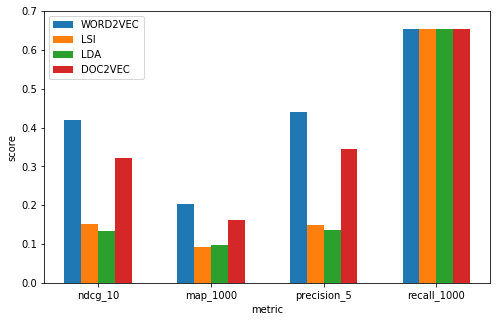

In [290]:
N = 4
ind = np.arange(N)
width = 0.15

plt.figure(figsize=(8, 5))
for k in range(len(test_scores)):
    plt.bar(ind + k*width,[ float(n) for n in test_scores_task2[k]], width, label = models_name[k])
    plt.legend()
    plt.xticks(ind + width*k / 2, ['ndcg_10', 'map_1000', 'precision_5', 'recall_1000'])
    plt.ylim(ymin=0.0, ymax=0.7)
    plt.xlabel('metric')
    plt.ylabel('score')
plt.show()

## Significance Testing to determine best performing model
In order to see more data, uncomment the below lines

In [291]:
test_scores2 = []
t_test_prefixes2 = ["WORD2VEC", "LSI", "LDA", "DOC2VEC"]

for i, prefix in enumerate(t_test_prefixes2):
    test_scores2.append([])
    run_output = evaluate_run_test(prefix, True)
    test_scores2[i].append(process_output_t_test(run_output))
    
#     print(prefix)
#     for score in test_scores2[i]:
#         for measure in score:
#             print(measure[-1])
#     print()

wins2 = np.zeros(4)
bonferroni_alpha2 = 0.00278

for i in range(len(test_scores2)):
    for j in range(i+1, 4):
        for m in range(3):
            p_val = scipy.stats.ttest_rel(column(test_scores2[i][0][m], 1), column(test_scores2[j][0][m], 1))[1]
            if(p_val < bonferroni_alpha2 and test_scores2[i][0][m][-1][1] > test_scores2[j][0][m][-1][1]):
                wins2[i] += 1
            elif(p_val < bonferroni_alpha2 and test_scores2[i][0][m][-1][1] < test_scores2[j][0][m][-1][1]):
                wins2[j] += 1
                
print("WORD2VEC,", "LSI,", "LDA,", "DOC2VEC")
print(wins2)

WORD2VEC, LSI, LDA, DOC2VEC
[ 9.  0.  0.  6.]


The best model has been determined to be Word2Vec, followed by Doc2Vec. The remanining two models, LSI and LDA, have low performance compared to the first two.

### Task 3: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval. You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**NOTE**: you can only perform this task if you have completely finished Task 1 and Task 2.

In this experiment, you will use the retrieval methods you implemented in Task 1 and Task 2 as features for the learning to rank model. Train your LTR model using 10-fold cross validation on the test set. For every query, first create a document candidate set using the top-1000 documents using TF-IDF. Secondly, compute query-document values using the retrieval models above and use them as features. Note that the feature values of different retrieval methods are likely to be distributed differently.

Your approach will definitely not be as good as the state-of-the-art since you are taking a pointwise approach, but we do not ask you to try pair- or listwise methods because they will be the main topic of the next assignment.

### Updated tf-dictionary creation
This cells create an updated tf_dictionary in order to save memory, due to our machines limitations.

In [70]:
def create_updated_tf_dictionary():
    tf_dictionary_test = {}
    for query in rankings:
        print(query, end=' ')
        for external_doc_id in rankings[query]:
            internal_doc_id = index.document_ids([external_doc_id])[0][1]
            if internal_doc_id not in tf_dictionary_test:
                tf_dictionary_test[internal_doc_id] = {}
                for token in index.document(internal_doc_id)[1]:
                    if token in tf_dictionary_test[internal_doc_id]:
                        tf_dictionary_test[internal_doc_id][token] += 1
                    else:
                        tf_dictionary_test[internal_doc_id][token] = 1
    return tf_dictionary_test

In [71]:
tf_dictionary_test = create_updated_tf_dictionary()
save_dictionary('tf_dictionary_test', tf_dictionary_test)

In [72]:
tf_dictionary = load_dictionary('tf_dictionary_test')

In [73]:
def parse_test_file():
    queries = {}
    with open('ap_88_89/qrel_test') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split(' ')
            if line[0] not in queries:
                queries[line[0]] = {}
            queries[line[0]][line[2]] = int(line[3])
    return queries

In [74]:
parsed_test_file = parse_test_file()
save_dictionary('parsed_test_file', parsed_test_file)

In [75]:
parsed_test_file = load_dictionary('parsed_test_file')

## Dataset creation
The plm scoring is not used, due to time limitations. Multiple matrices are created and later merged, in order to be able to keep everything in memory later.

In [200]:
def compute_metrics(external_doc_id, query, tokens, query_word2vec, query_doc2vec, query_lsi, query_lda):
    internal_doc_id = (index.document_ids([external_doc_id])[0])[1]
    doc = index.document(internal_doc_id)

    tf_idf_score = tf_idf(tokens, internal_doc_id, [])
    bm25_score = bm25(query, internal_doc_id, [0.75, 1.2, 1])
    jelinek_mercer_score = jelinek_mercer(query, internal_doc_id, [0.2])
    dirichlet_prior_score = dirichlet_prior(query, internal_doc_id, [1500])
    absolute_discounting_score = absolute_discounting(query, internal_doc_id, [0.9])
    # plm_score = plm(query, internal_doc_id, [500, 50, 'PASSAGE']) too long computation time
    word2vec_score = 2 - scipy.spatial.distance.cosine(query_word2vec, document_averages[external_doc_id])
    doc2vec_score = 2 - scipy.spatial.distance.cosine(query_doc2vec, document_vectors[external_doc_id])
    lsi_score = 2 - scipy.spatial.distance.cosine(query_lsi, document_topics[external_doc_id])
    lda_score = 2 - scipy.spatial.distance.cosine(query_lda, document_topics_2[external_doc_id])
    return [tf_idf_score, bm25_score, jelinek_mercer_score, dirichlet_prior_score, absolute_discounting_score, 
            word2vec_score, doc2vec_score, lsi_score, lda_score]
    
def matrix_from_query(query_id, documents):
    height = len(documents)
    width = 9
    matrix = np.zeros((height, width))
    
    query = test_queries[str(query_id)]
    tokens = set(index.tokenize(query))
    if('' in tokens):
        tokens.remove('')
        
    query_word2vec = query_to_word2vec(query_id)
    query_doc2vec = query_to_doc2vec(query_id)
    query_lsi = query_to_lsi(query_id)
    query_lda = query_to_lda(query_id)


    for i in range(len(documents)):
        scores = compute_metrics(documents[i], query, tokens, query_word2vec, query_doc2vec, query_lsi, query_lda)
        matrix[i] = scores
    return matrix

def y_from_query(query_id, documents):
    y = np.zeros((len(documents),))
    for i in range(len(documents)):
        external_doc_id = documents[i]
        if external_doc_id in parsed_test_file[str(query_id)]:
                y[i] = parsed_test_file[str(query_id)][external_doc_id]
    return y
    
def create_dataset():
    queries_list = sorted(list(rankings.keys()))
    for i in range(len(queries_list)):
        query = queries_list[i]
        print(query, end=' ')
        x = matrix_from_query(query, rankings[query])
        y = y_from_query(query, rankings[query])
        with open('npy/x_' + str(query) + '.npy', 'wb') as f:
            np.save(f, x)
        with open('npy/y_' + str(query) + '.npy', 'wb') as f:
            np.save(f, y)
            
def merge_dataset():
    X = None
    Y = None
    queries_list = sorted(list(rankings.keys()))
    for i in range(len(queries_list)):
        query = queries_list[i]
        with open('npy/x_' + str(query) + '.npy', 'rb') as f:
            x = np.load(f)
        with open('npy/y_' + str(query) + '.npy', 'rb') as f:
            y = np.load(f)
        if X is None:
            X = x
            Y = y
        else:
            X = np.vstack((X, x))
            Y = np.hstack((Y, y))
    return X, Y

In [ ]:
create_dataset()

In [204]:
X, Y = merge_dataset()

queries_list = sorted(list(rankings.keys()))
indexes_map = []
for query in queries_list:
    for d in rankings[query]:
        indexes_map.append((query, d))

## Logistic regression model training

In [205]:
def write_run_ltr(probabilities, indexes, run_name):
    associations = []
    for i in range(len(indexes)):
        associations.append((probabilities[i], indexes_map[indexes[i]]))
    associations.sort(key=lambda x: x[0], reverse=True)
    with open('runs/' + run_name + '.run', 'w') as f:
        for i in range(len(associations)):
            print(str(associations[i][1][0]) + ' Q0 ' + associations[i][1][1] + ' ' + str(i+1) + ' ' + str(associations[i][0]) + ' LTR', file=f)

In [210]:
model = LogisticRegression()
kf = KFold(n_splits=10)
i=0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model.fit(X_train, Y_train)
    probabilities = model.predict_proba(X_test)[:,1]
    write_run_ltr(probabilities, test_index, 'LTR_TEST_' + str(i))
    i += 1

## K-folds evaluations

In [268]:
print('fold (ndcg_10, map_1000, precision_5, recall_1000)')
for i in range(10):
    output = evaluate_run('LTR_TEST_' + str(i), True)
    print(i+1, process_output(output))

fold (ndcg_10, map_1000, precision_5, recall_1000)
1 ('0.6714', '0.3961', '0.6667', '0.7346')
2 ('0.3020', '0.1464', '0.3067', '0.3655')
3 ('0.3765', '0.1609', '0.4154', '0.5439')
4 ('0.3521', '0.2094', '0.3692', '0.6639')
5 ('0.4513', '0.1950', '0.5231', '0.6072')
6 ('0.4609', '0.3009', '0.4500', '0.8114')
7 ('0.5889', '0.1979', '0.6462', '0.5169')
8 ('0.4983', '0.3106', '0.4923', '0.7588')
9 ('0.4138', '0.1815', '0.4333', '0.6182')
10 ('0.4523', '0.2076', '0.4154', '0.5157')


## Model evaluation

In [212]:
runs = []
for i in range(10):
    with open('runs/LTR_TEST_' + str(i) + '.run') as f:
        lines = f.readlines()
        for line in lines:
            runs.append(line.replace('\n', ''))
        
with open('runs/LTR_TEST.run', 'w') as f:
    for line in runs:
        print(line, file=f)

In [303]:
test_scores_task3 = []
print('(ndcg_10, map_1000, precision_5, recall_1000)')
output = evaluate_run('LTR_TEST', True)
test_scores_task3.append(process_output(output))
print(process_output(output))

(ndcg_10, map_1000, precision_5, recall_1000)
('0.4806', '0.2446', '0.4967', '0.6528')


## Models plot

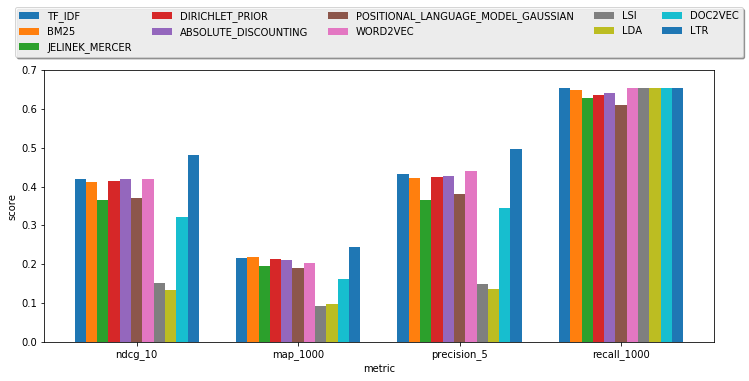

In [327]:
model_names = ["TF_IDF", "BM25", "JELINEK_MERCER", "DIRICHLET_PRIOR", "ABSOLUTE_DISCOUNTING", "POSITIONAL_LANGUAGE_MODEL_GAUSSIAN", "WORD2VEC", "LSI", "LDA", "DOC2VEC", "LTR"]
N = 4
ind = np.arange(N)
width = 0.07

test_scores_final = test_scores_task1 + test_scores_task2 + test_scores_task3

plt.figure(figsize=(12, 5))
for k in range(len(test_scores_final)):
    plt.bar(ind + k*width,[ float(n) for n in test_scores_final[k]], width, label = model_names[k])
    plt.xticks(ind + width*k / 2, ['ndcg_10', 'map_1000', 'precision_5', 'recall_1000'])
    plt.ylim(ymin=0.0, ymax=0.7)
    plt.xlabel('metric')
    plt.ylabel('score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=True, shadow=True)
plt.show()

## Significance Testing to determine best performing model

In [231]:
test_scores3 = []
t_test_prefixes3 = ["TF_IDF_TEST", "BM25_TEST", "JELINEK_MERCER_TEST_0.2", "DIRICHLET_PRIOR_TEST_1500", "ABSOLUTE_DISCOUNTING_TEST_0.9",
                    "POSITIONAL_LANGUAGE_MODEL_GAUSSIAN_TEST", "WORD2VEC", "LSI", "LDA", "DOC2VEC", "LTR_TEST"]


for i, prefix in enumerate(t_test_prefixes3):
    test_scores3.append([])
    run_output = evaluate_run_test(prefix, True)
    test_scores3[i].append(process_output_t_test(run_output))
    
#     print(prefix)
#     for score in test_scores3[i]:
#         for measure in score:
#             print(measure[-1])
#     print()
    
wins3 = np.zeros(11)
bonferroni_alpha3 = 0.00030

for i in range(len(test_scores3)):
    for j in range(i+1, 11):
        for m in range(3):
            p_val = scipy.stats.ttest_rel(column(test_scores3[i][0][m], 1), column(test_scores3[j][0][m], 1))[1]
            if(p_val < bonferroni_alpha3 and test_scores3[i][0][m][-1][1] > test_scores3[j][0][m][-1][1]):
                wins3[i] += 1
            elif(p_val < bonferroni_alpha3 and test_scores3[i][0][m][-1][1] < test_scores3[j][0][m][-1][1]):
                wins3[j] += 1

print("TF_IDF,", "BM25,", "JELINEK_MERCER,", "DIRICHLET_PRIOR,", "ABSOLUTE_DISCOUNTING,", "PLM_GAUSS,", "WORD2VEC,", "LSI,", "LDA,", "DOC2VEC,", "LTR")
print(wins3)

TF_IDF, BM25, JELINEK_MERCER, DIRICHLET_PRIOR, ABSOLUTE_DISCOUNTING, PLM_GAUSS, WORD2VEC, LSI, LDA, DOC2VEC, LTR
[ 10.  12.   6.  11.  10.   6.   9.   0.   0.   6.  19.]


This final ranking gives the order of the models by performance

1 **LTR**

2 **BM25**

3 **DIRICHLET_PRIOR**

4 **ABSOLUTE_DISCOUNTING** and **TF_IDF**

5 **WORD2VEC**

6 **JELINEK_MERCER** and **DOC2VEC** and **PLM_GAUSS**

7 **LSI** and **LDA**

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Do not send us the VirtualBox, but only the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file system structure as on the VirtualBox.
